# Expected Exposure simulation with QuantLib and Python

*Copyright (c) 2015 Matthias Groncki*


Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are met:

    - Redistributions of source code must retain the above copyright notice,
    this list of conditions and the following disclaimer.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDERS OR CONTRIBUTORS BE LIABLE
FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.

This disclaimer is taken from the QuantLib license

In [1]:
# import the used libraries
import numpy as np
import matplotlib.pyplot as plt
import QuantLib as ql
%matplotlib inline

In [2]:
# Setting evaluation date
today = ql.Date(7,4,2015)
ql.Settings.instance().setEvaluationDate(today)

In [3]:
# Setup Marketdata
rate = ql.SimpleQuote(0.03)
rate_handle = ql.QuoteHandle(rate)
dc = ql.Actual365Fixed()
yts = ql.FlatForward(today, rate_handle, dc)
yts.enableExtrapolation()
hyts = ql.RelinkableYieldTermStructureHandle(yts)
t0_curve = ql.YieldTermStructureHandle(yts)
euribor6m = ql.Euribor6M(hyts)

In [4]:
# Setup a dummy portfolio with two Swaps
def makeSwap(start, maturity, nominal, fixedRate, index, typ=ql.VanillaSwap.Payer):
    """
    creates a plain vanilla swap with fixedLegTenor 1Y
    
    parameter:
        
        start (ql.Date) : Start Date
        
        maturity (ql.Period) : SwapTenor
        
        nominal (float) : Nominal
        
        fixedRate (float) : rate paid on fixed leg
        
        index (ql.IborIndex) : Index
        
    return: tuple(ql.Swap, list<Dates>) Swap and all fixing dates
    
        
    """
    end = ql.TARGET().advance(start, maturity)
    fixedLegTenor = ql.Period("1y")
    fixedLegBDC = ql.ModifiedFollowing
    fixedLegDC = ql.Thirty360(ql.Thirty360.BondBasis)
    spread = 0.0
    fixedSchedule = ql.Schedule(start,
                                end, 
                                fixedLegTenor, 
                                index.fixingCalendar(), 
                                fixedLegBDC,
                                fixedLegBDC, 
                                ql.DateGeneration.Backward,
                                False)
    floatSchedule = ql.Schedule(start,
                                end,
                                index.tenor(),
                                index.fixingCalendar(),
                                index.businessDayConvention(),
                                index.businessDayConvention(),
                                ql.DateGeneration.Backward,
                                False)
    swap = ql.VanillaSwap(typ, 
                          nominal,
                          fixedSchedule,
                          fixedRate,
                          fixedLegDC,
                          floatSchedule,
                          index,
                          spread,
                          index.dayCounter())
    return swap, [index.fixingDate(x) for x in floatSchedule][:-1]

portfolio = [makeSwap(today + ql.Period("2d"),
                      ql.Period("5Y"),
                      1e6,
                      0.03,
                      euribor6m),
             makeSwap(today + ql.Period("2d"),
                      ql.Period("4Y"),
                      5e5,
                      0.03,
                      euribor6m,
                      ql.VanillaSwap.Receiver),
            ]

In [5]:
%%timeit
# Setup pricing engine and calculate the npv
engine = ql.DiscountingSwapEngine(hyts)
for deal, fixingDates in portfolio:
    deal.setPricingEngine(engine)
    deal.NPV()
    #print(deal.NPV())

The slowest run took 4.41 times longer than the fastest. This could mean that an intermediate result is being cached 
10000 loops, best of 3: 34.5 µs per loop


In [6]:
# Stochastic Process 

In [7]:
# Assume the model is already calibrated either historical or market implied
volas = [ql.QuoteHandle(ql.SimpleQuote(0.0075)),
         ql.QuoteHandle(ql.SimpleQuote(0.0075))]
meanRev = [ql.QuoteHandle(ql.SimpleQuote(0.02))]
model = ql.Gsr(t0_curve, [today+100], volas, meanRev, 16.)

In [8]:
process = model.stateProcess()

In [9]:
# Define evaluation grid
date_grid = [today + ql.Period(i,ql.Weeks) for i in range(0,52*6)]
for deal in portfolio:
    date_grid += deal[1]

date_grid = np.unique(np.sort(date_grid))
time_grid = np.vectorize(lambda x: ql.ActualActual().yearFraction(today, x))(date_grid)
dt = time_grid[1:] - time_grid[:-1]

print(len(time_grid)*1500*2*29e-6)

27.927


In [10]:
# Random number generator
seed = 1
urng = ql.MersenneTwisterUniformRng(seed)
usrg = ql.MersenneTwisterUniformRsg(len(time_grid)-1,urng)
generator = ql.InvCumulativeMersenneTwisterGaussianRsg(usrg)

In [13]:
#%%timeit
# Generate N paths
N = 1500
x = np.zeros((N, len(time_grid)))
y = np.zeros((N, len(time_grid)))
pillars = np.array([0.0, 0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
zero_bonds = np.zeros((N, len(time_grid), 12))
for j in range(12):
    zero_bonds[:, 0, j] = model.zerobond(pillars[j],
                                         0,
                                         0)
for n in range(0,N):
    dWs = generator.nextSequence().value()
    for i in range(1, len(time_grid)):
        t0 = time_grid[i-1]
        t1 = time_grid[i]
        x[n,i] = process.expectation(t0, 
                                     x[n,i-1], 
                                     dt[i-1]) + dWs[i-1] * process.stdDeviation(t0,
                                              x[n,i-1],
                                              dt[i-1])
        y[n,i] = (x[n,i] - process.expectation(0,0,t1)) / process.stdDeviation(0,0,t1)
        for j in range(12):
            zero_bonds[n, i, j] = model.zerobond(t1+pillars[j],
                                                 t1,
                                                 y[n, i])
                                                 

1 loops, best of 3: 19.7 s per loop


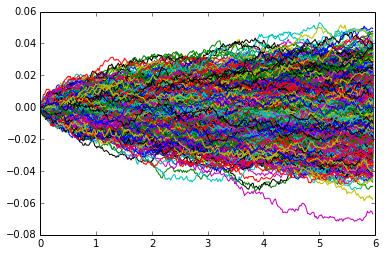

In [12]:
# plot the paths
for i in range(0,N):
    plt.plot(time_grid, x[i,:])

In [24]:
%%timeit
#Swap pricing under each scenario
npv_matrix = np.zeros((N,len(date_grid), len(portfolio)))
for p in range(0,N):
    for t in range(0, len(date_grid)):
        date = date_grid[t]
        ql.Settings.instance().setEvaluationDate(date)
        ycDates = [date, 
                   date + ql.Period(6, ql.Months)] 
        ycDates += [date + ql.Period(i,ql.Years) for i in range(1,11)]
        yc = ql.DiscountCurve(ycDates, 
                              zero_bonds[p, t, :], 
                              ql.Actual365Fixed())
        yc.enableExtrapolation()
        hyts.linkTo(yc)
        if euribor6m.isValidFixingDate(date):
            fixing = euribor6m.fixing(date)
            euribor6m.addFixing(date, fixing)
        for i in range(len(portfolio)):
            npv_matrix[p, t, i] = deal.NPV()
    ql.IndexManager.instance().clearHistories()
ql.Settings.instance().setEvaluationDate(today)
hyts.linkTo(yts)

1 loops, best of 3: 1min 10s per loop


In [23]:
# Calculate the portfolio npv by netting all NPV
portfolio_npv = np.sum(npv_matrix,axis=2)

In [3]:
# Plot the first 30 NPV paths
plt.figure(figsize=(7,5), dpi=300)
for i in range(0,30):
    plt.plot(time_grid, portfolio_npv[i,:])
plt.xlabel("Time in years")
plt.ylabel("NPV")
plt.title("Simulated npv paths")

NameError: name 'time_grid' is not defined

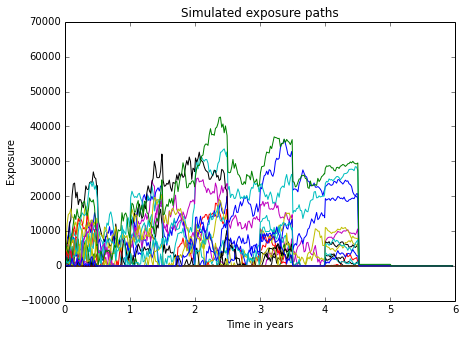

In [315]:
# Calculate the exposure
E = portfolio_npv.copy()
E[E<0]=0
# Plot the first 30 exposure paths
plt.figure(figsize=(7,5), dpi=600)
for i in range(0,30):
    plt.plot(time_grid, E[i,:])
plt.xlabel("Time in years")
plt.ylabel("Exposure")
plt.ylim([-10000,70000])
plt.title("Simulated exposure paths")


In [308]:
# Calculate the expected exposure
E = npv_matrix.copy()
E[E<0]=0
EE = np.sum(E, axis=0)/N

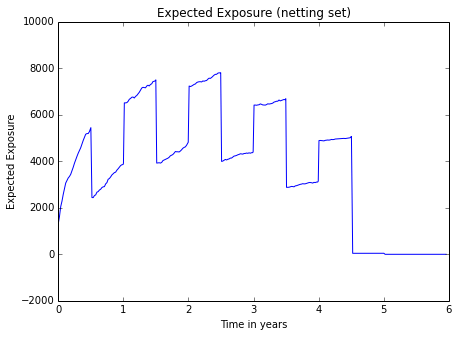

In [321]:
# plot the expected exposure path
plt.figure(figsize=(7,5), dpi=300)
plt.plot(time_grid, EE)
plt.xlabel("Time in years")
plt.ylabel("Expected Exposure")
plt.ylim([-2000,10000])
plt.title("Expected Exposure (netting set)")


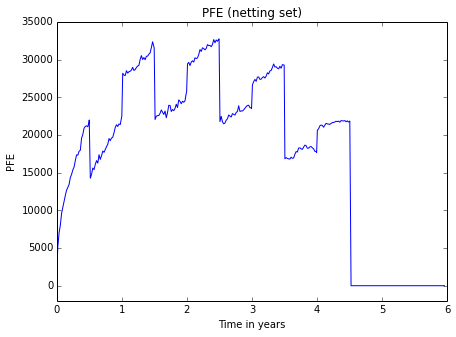

In [322]:
# Calculate the PFE curve (95% quantile)
PFE_curve = np.apply_along_axis(lambda x: np.sort(x)[0.95*N],0, E)

plt.figure(figsize=(7,5), dpi=300)
plt.plot(time_grid,PFE_curve)
plt.xlabel("Time in years")
plt.ylabel("PFE")
plt.ylim([-2000,35000])
plt.title("PFE (netting set)")

In [311]:
# calculate the maximum pfe
MPFE = np.max(PFE_curve)
MPFE

32737.839542311522

In [312]:
# alternative pfe 95% quantile of the maxima of each exposure paths
PFE = np.sort(np.max(E,axis=1))[0.95*N]
PFE

39643.707316833963